## Caso de estudio 1: Control del ángulo del motor en variables de estado

Dadas las ecuaciones del motor de corriente continua con las mediciones experimentales detalladas en la Fig. 1, se sabe que las ecuaciones son:

1. $$ \frac{di_a}{dt} = -\frac{R_A}{L_{AA}}i_a - \frac{K_m}{L_{AA}}\omega_r + \frac{1}{L_{AA}}v_a $$
2. $$ \frac{d\omega_r}{dt} = \frac{K_i}{J}i_a - \frac{B_m}{J}\omega_r - \frac{1}{J}T_L $$
3. $$ \frac{d\theta_t}{dt} = \omega_r $$

---

**Ítem [1]**  
Empleando los parámetros hallados en el Trabajo Práctico Nº1 para el Motor CC, implementar un sistema en variables de estado que controle el ángulo del motor, para consignas de π/2 y –π/2 cambiando cada 5 segundos y que el $ T_L $ es el descripto en la planilla de datos, comparando el desempeño con el obtenido con el PID digital del TP Nº1. Hallar el valor de integración Euler adecuado.

**Objetivo:** acelerar la dinámica del controlador verificando el resultado con las curvas del archivo `.xls` adjunto.

- **a.** Evitando que la tensión supere los 5 Volts en valor absoluto, especificar el tiempo de muestreo necesario para que el controlador cumpla el objetivo.  
- **b.** Asumiendo que no puede medirse directamente la corriente, **pero sí la velocidad y el ángulo**, proponer un controlador que logre el objetivo.  
- **c.** Determinar el efecto de la no linealidad en la acción de control, descripta en la Fig. 2, y verificar cuál es el máximo valor admisible de esa no linealidad.

![Caso 1 - imagen](extras/case1.png)


In [4]:
# !pip install numpy pandas matplotlib scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import place_poles

 ### 1. Modelo del Motor CC
 La representación en espacio de estados es:
 $$
 \dot{x} = A x + B u, \quad y = C x
 $$
 donde:
 $$
 x = \begin{bmatrix} i_a \\ \omega_r \\ \theta_r \end{bmatrix}, \quad
 u = \begin{bmatrix} v_a \\ T_L \end{bmatrix}, \quad
 y = \theta_r
 $$
 $$
 A = \begin{bmatrix}
 -\frac{R_A}{L_{AA}} & -\frac{K_m}{L_{AA}} & 0 \\
 \frac{K_i}{J} & -\frac{B_m}{J} & 0 \\
 0 & 1 & 0
 \end{bmatrix}, \quad
 B = \begin{bmatrix}
 \frac{1}{L_{AA}} & 0 \\
 0 & -\frac{1}{J} \\
 0 & 0
 \end{bmatrix}, \quad
 C = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}
 $$

In [66]:
# ------------------- Parámetros del Sistema -------------------
# Parámetros del motor (identificados experimentalmente)
Ra = 2.2781228953606902
Laa = 0.005187184919244553
Ki = 0.2618711775870197
Jm = 0.002848787974411428
Bm = 0.0014279727330389095
Km = 0.2499435593696499


# Parámetros del motor [originales]
# Ra = 2.27        # Resistencia de armadura [Ohm]
# Laa = 0.0047     # Inductancia de armadura [H]
# Ki = 0.25        # Constante de torque [N⋅m/A]
# Km = 0.25        # Constante de fuerza contraelectromotriz [V⋅s/rad]
# Bm = 0.00131     # Coeficiente de fricción viscosa [N⋅m⋅s/rad]
# Jm = 0.00233     # Momento de inercia [kg⋅m²]

# Ra=2.27;Laa=0.0047;Ki=0.25;Km=0.25;Bm=0.00131;Jm=0.00233; 

# Matrices del sistema en espacio de estados
A = np.array([
    [-Ra/Laa,   -Km/Laa,  0],
    [Ki/Jm,     -Bm/Jm,   0],
    [0,         1,        0]
])
B_va = np.array([[1/Laa], [0], [0]])
B_torque = np.array([[0], [-1/Jm], [0]])
B = np.hstack((B_va, B_torque))
C = np.array([[0, 0, 1]])



# autovalores del sistema
autovalores = np.linalg.eigvals(A)
print(f"Autovalores del sistema: {autovalores}") 

# tiempo de integracion
t_int = np.log(0.95) / np.min(np.real(autovalores))
# redondear a 4 decimales
t_int = round(t_int, 5)
print(f"Tiempo de integración: {t_int} s")
 

Autovalores del sistema: [   0.          -10.84191401 -428.84223831]
Tiempo de integración: 0.00012 s


Vamos a definir una funcion auxiliar, para realizar las simulaciones del sistema (más rapidamente que el controlador)

Simular con subpasos dentro de `sim_motor` permite capturar las dinámicas rápidas del sistema sin hacer más lenta toda la simulación (con controlador y observador). Mejoramos la precisión numérica y la estabilidad, manteniendo el controlador a un ritmo de muestreo más alto.  


In [69]:
def sim_motor(dt, x0, u, pasos_min=10):
    """
    Simula el sistema dx/dt = A x + B u durante dt,
    usando subpasos internos calculados en base a la dinámica más rápida del sistema.

    Parámetros:
    - dt_externo: paso externo de integración [s]
    - x0: estado actual (3x1)
    - u: entrada actual (2x1)
    Retorna:
    - x_f: estado al final de dt
    """
    h = t_int # calculado en base a la dinámica más rápida del sistema
    x = x0.copy()

    n_subpasos = int(np.ceil(dt / h))

    # Integrar con subpasos (Euler)
    for _ in range(n_subpasos):
        dx = A @ x + B @ u
        x += h * dx

    return x


## Integrador para la realimentación de estados
Para esto, antes agregamos el integrador (para que el error converja a cero)



El sistema ampliado se convierte en:

$$
\begin{bmatrix}
\dot{x}(t) \\
\dot{\xi}(t)
\end{bmatrix}
=
\begin{bmatrix}
A & 0 \\
-C & 0
\end{bmatrix}
\begin{bmatrix}
x(t) \\
\xi(t)
\end{bmatrix}
+
\begin{bmatrix}
B \\
0
\end{bmatrix}
u(t)

$$


Donde:

$$

A_a = \begin{bmatrix} A & 0 \\ -C & 0 \end{bmatrix}, \quad

x_a = \begin{bmatrix} x \\ \xi \end{bmatrix}

B_a = \begin{bmatrix} B \\ 0 \end{bmatrix}, \quad

E_a = \begin{bmatrix} 0 \\ 1 \end{bmatrix}, \quad
$$


In [70]:
# Primero agregamos el integrador y hacemos la matriz aumentada
A_aug = np.vstack((np.hstack((A, np.zeros((3,1)))), 
                   np.hstack((-C[0,:], 0)) ))

B_aug = np.vstack((B_va, 0))
C_aug = np.hstack((C, np.array([[0]])))

# Construiremos el observador de Luenberger

Tenemos 2 caminos para diseñar el observador:

1. Transformamos la matriz en la forma canonica observable, luego despejar para calcular la ganancia Ko (L)
2. Aprovechar el concepto de dualidad para hallar Ko(L)

En este caso iremos por la segunda opción. Ya que nos permite transformar el problema de diseño del observador en un problema de control dual.

Para el sistema original:
$$
\begin{align}
\dot{x} &= Ax + Bu \\
y &= Cx
\end{align}
$$

El sistema dual es:
$$
\begin{align}
\dot{x} &= A^T x + C^T u \\
y &= B^T x
\end{align}
$$

Donde:
 - $A_{dual} = A^T$ (transpuesta de $A$)
 - $B_{dual} = C^T$ (transpuesta de $C$)
 - $C_{dual} = B^T$ (transpuesta de $B$)

Si el sistema original es observable, el sistema dual es controlable, y viceversa.
Esto nos permite usar las técnicas de control (como ubicación de polos) para encontrar la ganancia del observador L (Ko)

La ganancia del observador L será la transpuesta de la ganancia K del controlador del sistema dual:
$L = K^T$


In [71]:
# Verificamos que el sistema original sea observable
O = np.hstack((B, A@B, (A)**2 @B))
rank_O = np.linalg.matrix_rank(O)

# Si el rango es igual a la dimensión del sistema, el sistema es observable
if rank_O == A.shape[0]:
    print("El sistema es observable")
else:
    print("El sistema no es observable")



# Sistema dual
A_dual = A.T
B_dual = C.T
C_dual = B_va.T

# Chequeo de dimensiones (no es necesario, lo dejo para debugging)
print("Dimensiones:")
print(f"A_dual: {A_dual.shape}")
print(f"B_dual: {B_dual.shape}")
print(f"C_dual: {C_dual.shape}")
 
print(f"\nA_dual\n: {A_dual}")


El sistema es observable
Dimensiones:
A_dual: (3, 3)
B_dual: (3, 1)
C_dual: (1, 3)

A_dual
: [[-439.18289608   91.92371631    0.        ]
 [ -48.18481763   -0.50125623    1.        ]
 [   0.            0.            0.        ]]


Elegimos los polos del observador de manera que el sistema sea estable y que el error converja a cero en el tiempo deseado. Evitamos que el observador sea demasiado rapido, para que no se vuelva inestable.


In [72]:
# Calculamos la dinámica más rápida del sistema original
max_pole = np.max(np.abs(np.linalg.eigvals(A)))

print(max_pole)
# Calculamos los polos del observador de manera que sea 4 veces más rapido que el sistema
# polos_observador = polos_sistema * 2 
# print(polos_observador)
 

 # Para este caso, consideramos que el tiempo de muestreo es 0.001 s
t_muestreo = 0.001

print("En teoría, los polos del observador deberían ser mayores a ", 10*max_pole)

# Se hace caso a la sugerencia de la catedra, y se eligen los siguientes polos 
# para el observador

polos_observador = np.array([-330, -200, -220]) 


428.84223830964004
En teoría, los polos del observador deberían ser mayores a  4288.4223830964


### Procedimiento para calcular la ganancia de realimentación

Recordemos que la matriz que determina la dinamica a lazo cerrado es:

$$ 
 A_{cl} = A_{dual} - B_{dual} \cdot K
$$
 
La ganancia K (valores de $k1$, $k2$, $k3$, $k4$) se calcula igualando los coeficientes del polinomio caracteristico del sistema en lazo cerrado con los coeficientes del polinomio deseado.

$$
det(sI - Acl) = det(sI - (A_{dual} - B_{dual} \cdot K)) = 0
$$

El polinomio caracteristico deseado es:

$$
(s - p_1)(s - p_2)(s - p_3) = s^3 + a_2s^2 + a_1s + a_0 = 0
$$

donde $p_1$, $p_2$ y $p_3$ son los polos deseados del observador en terminos de $k1$, $k2$, $k3$, $k4$ (K).

Los coeficientes $a_i$ se obtienen expandiendo el polinomio:

$$
a_2 = -(p_1 + p_2 + p_3)
$$

$$
a_1 = p_1p_2 + p_1p_3 + p_2p_3
$$

$$
a_0 = -p_1p_2p_3
$$


Todo esto se puede sintetizar con la siguiente función en python: 

In [73]:
K = place_poles(A_dual, B_dual, polos_observador).gain_matrix

print(f"Ganancia K del sistema dual: {K}")

Ganancia K del sistema dual: [[-56058.4071205   41509.56888982    310.31584768]]


Debemos recordar que la ganancia K es la transpuesta de la ganancia L del observador, por lo que debemos tomar la transpuesta de la ganancia K para obtener la ganancia L.

In [74]:
L = K.T
print(f"Ganancia L del observador: {L}")

Ganancia L del observador: [[-56058.4071205 ]
 [ 41509.56888982]
 [   310.31584768]]


Ahora verificamos que los polos del observador sean los deseados, recordando que la matriz que determina la dinamica del observador es:
$$
A_{observador} = A - L \cdot C
$$

In [78]:
polos_observador_obtenidos = np.linalg.eigvals(A - L @ C)
print(f"Polos del observador obtenidos: {polos_observador_obtenidos}")

# El error debería converger a cero en :
tiempo_convergencia_estimado = 4 / np.min(polos_observador_obtenidos)
print(f"Tiempo estimado de convergencia del error: {tiempo_convergencia_estimado:.4f} s")



Polos del observador obtenidos: [-330. -220. -200.]
Tiempo estimado de convergencia del error: -0.0121 s


## Implementación y comparación con las mediciones

Se procerá a comparar los resultados medidos con los resultados observados.

In [79]:
# !pip install openpyxl

# Carga del archivo .xlsx
datos = pd.read_excel('./data/Curvas_Medidas_Motor_2025_v.xlsx')

# Extraer columnas relevantes
t_med = datos['Tiempo [Seg.]'].values        
va_med = datos['Tensión [V]'].values      
ia_med = datos['Corriente en armadura [A]'].values  
wr_med = datos['Velocidad angular [rad /seg]'].values 
tl_med = datos['Torque'].values  


Simulamos el modelo estimado (TP1)

In [80]:
# Tiempo de muestreo
dt = t_med[1] - t_med[0]

# Inicialización de variables
N = len(t_med)
x = np.zeros((3, N))  # [ia, w, theta]

# Simulación del modelo real
for k in range(N - 1):
    u_k = np.array([va_med[k], tl_med[k]])  # entrada en t_k
    dx = A @ x[:, k] + B @ u_k
    x[:, k+1] = x[:, k] + dt * dx


Simulamos el observador:

In [84]:
# Inicialización del observador
x_hat = np.zeros((3, N))  # estimación de [ia, w, theta]
error_obs = np.zeros((3, N))

for k in range(N - 1):
    u_k = np.array([va_med[k], tl_med[k]])
    y_k = x[2, k]               # salida real (solo para simular el observador)
    y_hat_k = C @ x_hat[:, k]   # salida estimada

    # Observador de Luenberger
    dx_hat = A @ x_hat[:, k] + B @ u_k + L @ (y_k - y_hat_k)
    x_hat[:, k+1] = x_hat[:, k] + dt * dx_hat
    error_obs[:, k] = x[:, k] - x_hat[:, k]


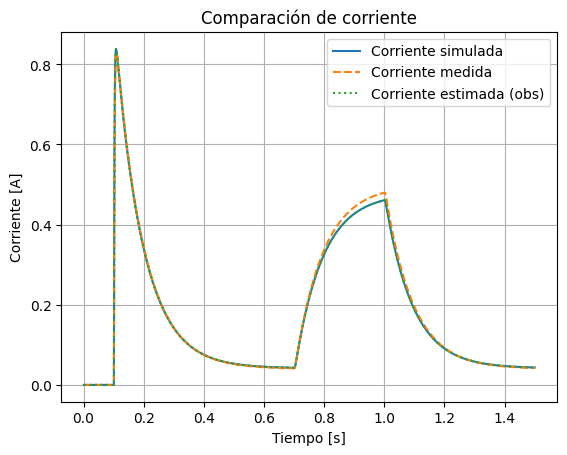

In [85]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t_med, x[0], label='Corriente simulada')
plt.plot(t_med, ia_med, label='Corriente medida', linestyle='--')
plt.plot(t_med, x_hat[0], label='Corriente estimada (obs)', linestyle=':')
plt.title("Comparación de corriente")
plt.xlabel("Tiempo [s]")
plt.ylabel("Corriente [A]")
plt.legend()
plt.grid()

# Simulación del sistema con Controlador + Observador


In [87]:
t_final = 10
dt = 0.001
N = int(t_final / dt)

# condiciones iniciales 

X = np.zeros((3, 1))       # Estado real del sistema: [ia, ω, θ]
x_hat = np.zeros((3, 1))   # Estado estimado por el observador
int_err = 0                    # Integrador del error
TL_max = 0.12              # Torque máximo de perturbación


e = np.zeros(N)            # Error entre referencia y salida real
e_obs = np.zeros((3, N))   # Error entre estado real y estimado por el observador
x1, x2, x3 = np.zeros(N), np.zeros(N), np.zeros(N)  # Estados reales
acc = np.zeros(N)          # Entrada de control (tensión)
TL_hist = np.zeros(N)      # Torque aplicado
theta_ref_hist = np.zeros(N)  # Historial de referencia de posición

In [89]:
for k in range(N):
    t_actual = k * dt

    # --- Definición de referencia de posición y perturbación ---
    theta_ref = np.pi / 2 if t_actual <= 5 else -np.pi / 2
    TL_aplicado = TL_max if t_actual > 0.7 else 0

    # --- Salida real del sistema (posición angular) ---
    y = (C @ X)[0]

    # --- Cálculo del error y acción de control ---
    e[k] = theta_ref - y
    u = -(L @ np.vstack([x_hat, int_err]).flatten())[0]
    acc[k] = u

    # --- Simulación del sistema real con subpasos internos ---
    entrada = np.array([u, TL_aplicado])
    X = sim_motor(dt, X, entrada)

    # --- Observador de Luenberger ---
    x_hat_dot = A @ x_hat + B * u + L @ (y - C @ x_hat)
    x_hat += x_hat_dot * dt

    # --- Integrador del error (para control integral) ---
    int_err += e[k] * dt

    # --- Registro de errores y estados ---
    e_obs[:, k] = (X - x_hat).flatten()
    x1[k], x2[k], x3[k] = X.flatten()
    TL_hist[k] = TL_aplicado
    theta_ref_hist[k] = theta_ref


/tmp/ipykernel_7400/207010226.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e[k] = theta_ref - y


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 1)